In [28]:
import os
import geopandas as gpd
from pyproj import Proj, transform
import pandas as pd
from shapely.wkt import loads
from pyproj import Transformer
import matplotlib.pyplot as plt
from shapely.geometry import Point
import csv

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')
gdf0 = gpd.GeoDataFrame(gpd.read_file("ECMC_Flowline_Data_Access/COGCC_Form44_Off_Location_Flowlines_Approved_CONFIDENTIAL.gdb"))
gdf1 = gpd.GeoDataFrame(gpd.read_file("ECMC_Flowline_Data_Access/COGCC_Form44_Crude_Oil_Produced_Water_Transfer_Flowlines_Approved_CONFIDENTIAL.gdb"))
flowlines = pd.read_excel('FlowlineSpreadsheet_Mines.xlsx')
spills = pd.read_excel('Flowline-Related Spills (2022).xlsx')

In [13]:
gdf.head()

,Operator,Fluid,Material,Diam_in,Status,Length_ft,Doc_Num,SHAPE_Length,geometry
0,SIMCOE LLC,Produced Water,Carbon Steel,2.000,Active,531.01,402902791,161.921176,"MULTILINESTRING ((239975.814 4103152.657, 2399..."
1,SIMCOE LLC,Produced Water,Fiberglass,3.000,Active,1916.17,402870670,584.211077,"MULTILINESTRING ((265499.034 4101255.110, 2654..."
2,SIMCOE LLC,Produced Water,Fiberglass,3.000,None,4.56,402852005,1.389643,"MULTILINESTRING ((266252.146 4109140.691, 2662..."
3,SIMCOE LLC,Produced Water,Fiberglass,3.000,Active,5.23,402902791,1.594278,"MULTILINESTRING ((256997.527 4117598.038, 2569..."
4,NOBLE ENERGY INC,Produced Water,Flexsteel,8.625,Active,122.93,403368004,37.456167,"MULTILINESTRING ((538921.819 4444764.256, 5389..."


<Axes: >

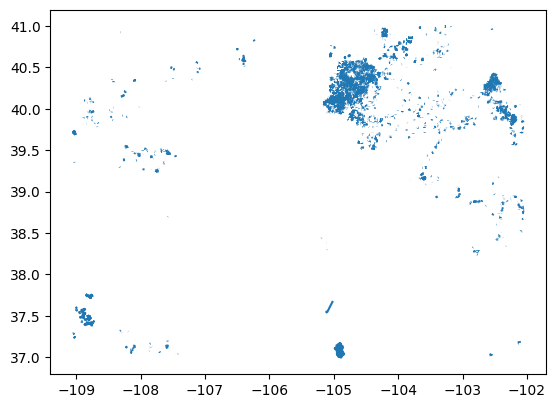

In [30]:
from shapely.geometry import Point, LineString
if 'geometry' not in flowlines.columns:
    flowlines['geometry'] = ''

for index, row in flowlines.iterrows():
    geom = LineString([(row['STARTLONG'],row['STARTLAT']),(row['ENDLONG'],row['ENDLAT'])])
    flowlines.at[index,'geometry'] = geom

fl_gdf = gpd.GeoDataFrame(flowlines, geometry='geometry', crs='EPSG:4326')
fl_gdf.plot()

In [32]:
if gdf0.crs != gdf1.crs:
    gdf1.to_crs(gdf.crs, inplace=True)

gdf = pd.concat([gdf0,gdf1],ignore_index=True)
gdf.head(1)

,Operator,Fluid,Material,Diam_in,Status,Length_ft,Doc_Num,SHAPE_Length,geometry
0,EVERGREEN NATURAL RESOURCES LLC,Gas,polly,4.0,Active,2277.71,403322934,693.972162,"MULTILINESTRING ((524642.670 4117088.796, 5246..."


In [33]:
if fl_gdf.crs != gdf.crs:
    fl_gdf.to_crs(gdf.crs, inplace=True)
    print('Change fl crs to gdf crs')

Change fl crs to gdf crs


In [14]:
spills.columns

Index([                'trkg_num',            'Operator Name',
                   'operator_num',            'incident_date',
                  'facility_type',               'Spill_Desc',
                         'county',               'Spill Type',
                     'Root Cause',     'Preventative Measure',
                'Root Cause Type', 'Detailed Root Cause Type',
                           'Long',                      'Lat',
                    'oil_spilled',            'oil_recovered',
                   'cond_spilled',           'cond_recovered',
                     'PW_spilled',             'PW_recovered',
               'drilling_spilled',       'drilling_recovered',
                   'frac_spilled',           'frac_recovered',
                  'other_spilled',          'other_recovered',
          'other_spilled_specify',          'facility_status',
                          'Basin',               'Gathering?',
                      'Metallic?',                     

In [17]:
pd.options.display.max_columns = None
spl_gdf = gpd.GeoDataFrame(spills, geometry=gpd.points_from_xy(spills.Long,spills.Lat), crs='EPSG:4326')
spl_gdf.head(2)

,trkg_num,Operator Name,operator_num,incident_date,facility_type,Spill_Desc,county,Spill Type,Root Cause,Preventative Measure,Root Cause Type,Detailed Root Cause Type,Long,Lat,oil_spilled,oil_recovered,cond_spilled,cond_recovered,PW_spilled,PW_recovered,drilling_spilled,drilling_recovered,frac_spilled,frac_recovered,other_spilled,other_recovered,other_spilled_specify,facility_status,Basin,Gathering?,Metallic?,NaN,nan.1,On Location?,Fac or Loc ID,geometry
0,400768997,PETRON DEVELOPMENT COMPANY,69760,42005,WELL,A backup restraint that keeps our drive head o...,WASHINGTON,NaN,A backup restraint that keeps our drive head o...,We replaced the restraining chain with a heavi...,Incorrect Operation,Improper Procedures,-102.84418,40.14439,1.0,NaN,0.0,NaN,40.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,DENVER JULESBURG BASIN,Non-Gathering,Unknown,NaN,NaN,NaN,NaN,POINT (-102.84418 40.14439)
1,400763041,PIONEER NATURAL RESOURCES USA INC,10084,42006,WATER GATHERING SYSTEM/LINE,One inch valve on the waterline inside the met...,LAS ANIMAS,NaN,One inch valve on the waterline inside the met...,The valve has been replaced and everything is ...,Natural Force Damage,Valve Freeze,-104.90956,37.19037,0.0,NaN,0.0,NaN,20.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,RATON BASIN,Non-Gathering,Unknown,NaN,NaN,NaN,NaN,POINT (-104.90956 37.19037)


In [39]:
gdf['spill50m'] = 0
if spl_gdf.crs != gdf.crs:
    spl_gdf.to_crs(gdf.crs,inplace=True)
    print('Fix spills gdf crs')

for index, row in spl_gdf.iterrows():
    geom = row['geometry'].buffer(50)
    select = gdf[gdf.intersects(geom)].copy()
    #if select.shape[0] == 0:
    #    geom = row['geometry'].buffer(150)
    #    select = gdf[gdf.intersects(geom)].copy()

    for i2, r2 in select.iterrows()  :
        gdf.at[i2,'spill50m'] = r2['spill50m'] + 1
    if select.shape[0] != 1:
        print(select.shape[0],end='|')
        continue
    for col in list(gdf):
        if col == 'geometry':

            continue
        spl_gdf.at[index, col] = select[col].values[0]
    print('.',end='')

0|8|20|6|3|8|0|11|3|20|10|0|.12|7|4|.0|0|4|2|0|0|4|6|0|0|9|17|0|19|6|0|0|0|104|126|4|6|2|411|398|.0|4|0|17|0|18|5|0|2|6|0|0|3|0|.38|3|0|3|7|4|.11|34|4|0|.0|0|.0|0|0|0|0|8|0|12|31|6|7|0|50|3|0|0|2|0|0|0|4|7|10|0|0|0|0|54|23|0|0|0|28|54|2|87|99|2|13|0|3|2|0|51|2|28|0|0|6|.0|.16|0|14|10|8|85|0|0|3|0|0|0|0|35|12|11|0|0|15|9|17|2|0|3|4|16|0|0|4|0|3|2|4|.0|.5|0|0|2|2|13|7|2|2|14|10|0|3|5|3|0|0|0|6|0|17|3|81|0|2|4|3|0|10|.0|0|0|14|2|0|0|9|24|0|0|0|0|3|0|2|106|0|.0|0|9|0|0|0|2|10|12|0|0|2|4|4|30|30|50|3|0|34|2|30|0|0|30|6|0|35|5|44|0|0|2|0|2|28|5|2|38|0|5|12|31|.0|0|8|6|.20|55|2|0|0|2|6|15|2|3|0|2|22|0|5|0|0|6|5|5|3|33|0|3|.2|0|34|.4|0|10|4|23|.5|4|0|0|0|.17|17|51|3|17|.3|101|34|.2|2|6|2|0|.0|48|0|..0|2|7|69|.0|2|88|.105|8|17|5|6|0|17|0|0|.0|23|0|0|3|8|2|54|17|2|0|17|2|.103|..2|2|20|5|0|2|15|68|4|108|17|.24|94|43|2|0|0|0|0|.7|0|0|0|30|0|0|25|3|11|9|33|10|3|20|6|0|.2|0|0|0|3|13|2|5|4|25|.3|0|2|3|51|9|3|36|..2|0|.90|10|2|.16|2|15|0|0|.0|0|.24|34|5|0|0|0|2|16|5|41|0|0|0|.18|0|6|0|2|.7|.36|2|0|0|0

In [18]:
gdf.crs

<Projected CRS: EPSG:26913>
Name: NAD83 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 108°W and 102°W - onshore and offshore. Canada - Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Colorado; Montana; Nebraska; New Mexico; North Dakota; Oklahoma; South Dakota; Texas; Wyoming.
- bounds: (-108.0, 28.98, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [38]:
spl_gdf[spl_gdf.Operator.notnull()].head()

,trkg_num,Operator Name,operator_num,incident_date,facility_type,Spill_Desc,county,Spill Type,Root Cause,Preventative Measure,Root Cause Type,Detailed Root Cause Type,Long,Lat,oil_spilled,oil_recovered,cond_spilled,cond_recovered,PW_spilled,PW_recovered,drilling_spilled,drilling_recovered,frac_spilled,frac_recovered,other_spilled,other_recovered,other_spilled_specify,facility_status,Basin,Gathering?,Metallic?,NaN,nan.1,On Location?,Fac or Loc ID,geometry,Operator,Fluid,Material,Diam_in,Status,Length_ft,Doc_Num,SHAPE_Length
4,400764760,PIONEER NATURAL RESOURCES USA INC,10084,42008,WELL,"PC well head torqued up and broke 2"" line at f...",LAS ANIMAS,NaN,PC well head torqued up for an unknown reason ...,"The old corroded 2"" pipe at the wellhead has b...",Corrosion,Corrosion Type Unknown,-104.832020,37.076170,0.0,NaN,0.0,NaN,2000.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,RATON BASIN,Non-Gathering,Metallic,NaN,NaN,NaN,NaN,POINT (514931.284 4103335.406),EVERGREEN NATURAL RESOURCES LLC,Produced Water,SDR-7,4.0,Active,1589.79,402316492.0,484.376132
5,400765914,XTO ENERGY INC,100264,42009,WATER GATHERING SYSTEM/LINE,Isolation valve ruptured due to freeze. Line ...,LAS ANIMAS,NaN,A block valve on a dischargeable water line fr...,It is procedure to make sure all discharge poi...,Natural Force Damage,Valve Freeze,-104.919330,37.139480,0.0,NaN,0.0,NaN,509.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,RATON BASIN,Non-Gathering,Unknown,NaN,NaN,NaN,NaN,POINT (507164.568 4110348.568),TIMBER CREEK OPERATING LLC,Produced Water,HDPE,4.0,Active,5664.46,402216216.0,1725.836550
8,400768543,PIONEER NATURAL RESOURCES USA INC,10084,42014,WELL,"Lease Operator found 2"" ball vale on water lin...",LAS ANIMAS,NaN,Lack of communication among Lease Operators be...,Valve has been closed and Lease Operators spok...,Incorrect Operation,Valve Misalignment,-104.915580,37.259790,0.0,NaN,0.0,NaN,20.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,RATON BASIN,Non-Gathering,Unknown,NaN,NaN,NaN,NaN,POINT (507485.728 4123695.691),EVERGREEN NATURAL RESOURCES LLC,Produced Water,SDR-7,2.0,Active,913.30,402316492.0,278.261485
12,400775787,FOUNDATION ENERGY MANAGEMENT LLC,10112,42023,FLOWLINE,A broken valve can was discovered on the Davis...,RIO BLANCO,NaN,NaN,NaN,Unknown,Unknown,-109.046369,39.716919,0.0,NaN,0.0,NaN,15.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,DOUGLAS CREEK ARCH,Non-Gathering,Unknown,NaN,NaN,NaN,NaN,POINT (153127.747 4404172.650),FOUNDATION ENERGY MANAGEMENT LLC,Multiphase,HDPE,4.0,Active,12902.72,402800318.0,3936.983455
16,400779819,AUGUSTUS ENERGY RESOURCES LLC,10489,42027,WELL,The water line at the surface riser froze and ...,YUMA,NaN,NaN,NaN,Natural Force Damage,Line Freeze,-102.546589,40.077328,0.0,NaN,0.0,NaN,20.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,DENVER JULESBURG BASIN,Non-Gathering,Unknown,NaN,NaN,NaN,NaN,POINT (709197.067 4439224.514),OWN RESOURCES OPERATING LLC,Produced Water,HDPE,1.0,Active,2467.02,402538929.0,752.050500


In [41]:
gdf[['spill50m']].describe()

,spill50m
count,259979.000000
mean,0.062286
std,0.288059
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,19.000000


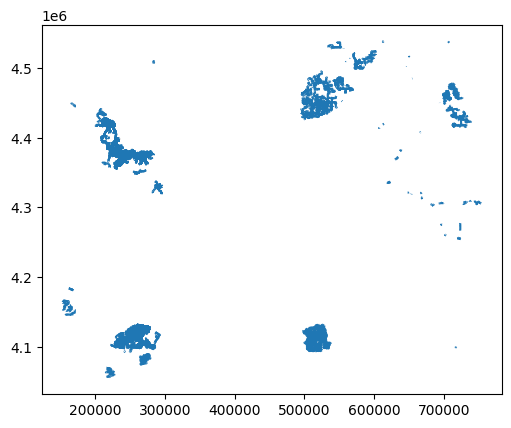

In [5]:
gdf.plot()
plt.show()

In [45]:
gdf.shape[0], gdf[gdf.spill50m != 0].shape[0]

(259979, 14204)

In [20]:
[x for x in spl_gdf.columns if x in gdf.columns]

['geometry']